<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Все-функции" data-toc-modified-id="Все-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Все функции</a></span><ul class="toc-item"><li><span><a href="#Функции-перевода-изображения-в-монохромный-формат-и-resize." data-toc-modified-id="Функции-перевода-изображения-в-монохромный-формат-и-resize.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Функции перевода изображения в монохромный формат и resize.</a></span></li><li><span><a href="#Функции-разрезания-на-ленты" data-toc-modified-id="Функции-разрезания-на-ленты-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функции разрезания на ленты</a></span><ul class="toc-item"><li><span><a href="#Создание-матриц-&quot;внешнего-ленточного-умножения&quot;-на-примере-матриц-A-и-B" data-toc-modified-id="Создание-матриц-&quot;внешнего-ленточного-умножения&quot;-на-примере-матриц-A-и-B-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Создание матриц "внешнего ленточного умножения" на примере матриц A и B</a></span></li></ul></li><li><span><a href="#Функции-ленточного-умножения-(block_outer_product_decomposition)" data-toc-modified-id="Функции-ленточного-умножения-(block_outer_product_decomposition)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Функции ленточного умножения (block_outer_product_decomposition)</a></span><ul class="toc-item"><li><span><a href="#Функция-внешнего-ленточного-умножения-двух-матриц" data-toc-modified-id="Функция-внешнего-ленточного-умножения-двух-матриц-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Функция внешнего ленточного умножения двух матриц</a></span></li><li><span><a href="#Ленточное-умножение-матрицы-на-транспонированную" data-toc-modified-id="Ленточное-умножение-матрицы-на-транспонированную-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Ленточное умножение матрицы на транспонированную</a></span></li></ul></li><li><span><a href="#Ленточное-умножение-для-разных-вариантов-нормализации" data-toc-modified-id="Ленточное-умножение-для-разных-вариантов-нормализации-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Ленточное умножение для разных вариантов нормализации</a></span></li><li><span><a href="#Функция-рисования-списка-картинок" data-toc-modified-id="Функция-рисования-списка-картинок-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Функция рисования списка картинок</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time as tm

from skimage import io, color, img_as_float
from scipy.ndimage import map_coordinates
import cv2 


# Все функции

## Функции перевода изображения в монохромный формат и resize. 
А также функции умножения матрицы на транспонированную и различных нормализаций. 
Вдруг понадобятся ;-) 

In [2]:
t1_itogo = tm.time()

def monochrome(rgb_image):
    if len(rgb_image.shape) == 2:  # Проверяем, если изображение уже двумерное
        print("Изображение уже монохромное.")
        return rgb_image  # Возвращаем исходное изображение
    else:
        coeffs = np.array([0.299, 0.587, 0.114])
        return rgb_image @ coeffs


def resize_and_monochrome (picture, k):
    new_size = (round(picture.shape[1]/k), round(picture.shape[0]/k))
    picture = cv2.resize(picture, new_size, interpolation=cv2.INTER_AREA)
    picture_monochrome = monochrome(picture)
    return picture, picture_monochrome



In [3]:
def normalize_image(im):   
    im_res = im - np.min(im)
    return (1 / np.max(im_res)) * im_res

def norm_columns(x):
    columns_sums = np.sum(x, axis=0)
    columns_sums[columns_sums == 0] = np.finfo(float).eps
    # Убедимся, что нормализация применяется корректно
    return x / columns_sums[np.newaxis, :]

# поправила norm_rows, а то там появляется деление на ноль
def norm_rows(x):
    row_sums = np.sum(x, axis=1)
    # Замена нулей на очень маленькое число, чтобы избежать деления на ноль
    row_sums[row_sums == 0] = np.finfo(float).eps
    return x / row_sums[:, np.newaxis]


def trans_mult(A):
    result = normalize_image(np.dot(monochrome(A), np.transpose(monochrome(A))))
    return result

def trans_mult_norm(A):
    result = normalize_image(np.dot(norm_rows(monochrome(A)), norm_columns(np.transpose(monochrome(A)))))
    return result

def trans_mult_norm_plus_1(A):
    B = A+1
    result = normalize_image(np.dot(norm_rows(monochrome(B)), norm_columns(np.transpose(monochrome(B)))))
    return result

def normalize_image_signed(img):
    img1 = img - np.min(img)
    img2 = (2 / np.max(img1)) * img1
    return img2 - 1


def trans_mult_signed(A):
    B = normalize_image_signed(monochrome(A))
    result = normalize_image(np.dot(B, np.transpose(B)))
    return result

## Функции разрезания на ленты

### Создание матриц "внешнего ленточного умножения" на примере матриц A и B

In [4]:
# А теперь возьмем m x n и n x k

num_rows_A = 7
num_columns_A = 9
strip_width = 2
number_strips_A = num_columns_A // strip_width if num_columns_A % strip_width == 0 else num_columns_A // strip_width + 1
 

A = np.random.randint(-10, 21, size=(num_rows_A, num_columns_A))

# Разделение матрицы A на number_strips матриц размером num_rows_A*strip_width и одну матрицу "остатка" num_rows*last_strip 
# last_strip = num_columns_A%strip_width

# вот вертикальные Ленты", получившиеся из матрицы А
sub_matrices_A = np.array_split(A, number_strips_A, axis=1)




num_rows_B = 9
num_columns_B = 5
strip_width = 2
number_strips_B = num_rows_B // strip_width if num_rows_B % strip_width == 0 else num_rows_B // strip_width + 1
# last_strip_B = num_rows_B%strip_width пока закомментим

B = np.random.randint(-3, 10, size=(num_rows_B, num_columns_B))


# вот горизонтальные ленты, получившиеся из матрицы В 
sub_matrices_B = np.array_split(B, number_strips_B, axis=0)


print('Это у нас вторая вертикальная  "лента". Когда режем А.')
print(sub_matrices_A[1])
print()
print('Это у нас вторая горизонтальная  "лента". Когда режем В')
print(sub_matrices_B[1])
print()


print('форма вертикальных лент, нарезанных из матрицы А', sub_matrices_A[1].shape)
print('форма горизонтальных лент, нарезанных из матрицы В',sub_matrices_B[1].shape)
print()

#создаем множество С
C = [0] * len(sub_matrices_A)


#а вот теперь само умножение вертикальных "лент" на горизонтальные
for i in range(len(sub_matrices_A)):
    print('матрица С номер ',i+1,':')
    C[i] = sub_matrices_A[i].dot(sub_matrices_B[i])
    print(C[i])
    print()


Это у нас вторая вертикальная  "лента". Когда режем А.
[[13 14]
 [17 16]
 [10 -7]
 [ 2  7]
 [ 3 -7]
 [-3 -6]
 [-7 12]]

Это у нас вторая горизонтальная  "лента". Когда режем В
[[ 0 -1  5  3  7]
 [ 9  3  9 -2  8]]

форма вертикальных лент, нарезанных из матрицы А (7, 2)
форма горизонтальных лент, нарезанных из матрицы В (2, 5)

матрица С номер  1 :
[[ 176   30   80  112   58]
 [ -80    6  -56  -46  -46]
 [ -32   52  -72   -6  -68]
 [ 136  -51  136   68  119]
 [  48   -2   32   28   26]
 [-112  -22  -48  -72  -34]
 [  80   82  -32   68  -42]]

матрица С номер  2 :
[[126  29 191  11 203]
 [144  31 229  19 247]
 [-63 -31 -13  44  14]
 [ 63  19  73  -8  70]
 [-63 -24 -48  23 -35]
 [-54 -15 -69   3 -69]
 [108  43  73 -45  47]]

матрица С номер  3 :
[[  7  -8  -6   5  36]
 [ 26 -36   6  50 162]
 [ 15 -28  36  65 126]
 [ 15  -8 -54 -35  36]
 [ 34 -48  12  70 216]
 [ 24 -44  54 100 198]
 [  7 -24  66  85 108]]

матрица С номер  4 :
[[ 16  26   9 -44 -17]
 [ 25  32   4 -63 -28]
 [ 24  24  -4 -56

## Функции ленточного умножения (block_outer_product_decomposition)

### Функция внешнего ленточного умножения двух матриц

In [5]:
def block_outer_product_decomposition(A, B, strip_width):
    num_strips_A = A.shape[1] // strip_width if A.shape[1] % strip_width == 0 else A.shape[1] // strip_width + 1
    sub_matrices_A = np.array_split(A, number_strips_A, axis=1)
    
    
    # печать второй ленты потом уберем, это для проверки
    
    print('Это у нас вторая вертикальная  "лента". Когда режем А.')
    print(sub_matrices_A[1])
    print()
    
    number_strips_B = num_rows_B // strip_width if num_rows_B % strip_width == 0 else num_rows_B // strip_width + 1
    sub_matrices_B = np.array_split(B, number_strips_B, axis=0)
    
    print('Это у нас вторая горизонтальная  "лента". Когда режем В.')
    print(sub_matrices_B[1])
    print()
    
    print('форма вертикальных лент, нарезанных из матрицы А', sub_matrices_A[1].shape)
    print('форма горизонтальных лент, нарезанных из матрицы В',sub_matrices_B[1].shape)
    print()
    
    C = [0] * len(sub_matrices_A)


    #а вот теперь само умножение вертикальных "лент" на горизонтальные
    for i in range(len(sub_matrices_A)):
        print('матрица С номер ',i+1,':')
        C[i] = sub_matrices_A[i].dot(sub_matrices_B[i])
        print(C[i])
        print()
    return C
# а почему после return обязательно печатиается то, что  return? спросить у ChatGPT

In [6]:
# проверяем работу функции ленточного умножения матриц

num_rows_A = 7
num_columns_A = 9
A = np.random.randint(-10, 21, size=(num_rows_A, num_columns_A))

num_rows_B = 9
num_columns_B = 5
B = np.random.randint(-3, 10, size=(num_rows_B, num_columns_B))


block_outer_product_decomposition(A, B, 2)

Это у нас вторая вертикальная  "лента". Когда режем А.
[[ 14  -9]
 [ -7  11]
 [ -6   0]
 [-10  11]
 [  5   2]
 [  6  18]
 [  2   1]]

Это у нас вторая горизонтальная  "лента". Когда режем В.
[[ 0  8  6  2  3]
 [ 4  9  6 -2  0]]

форма вертикальных лент, нарезанных из матрицы А (7, 2)
форма горизонтальных лент, нарезанных из матрицы В (2, 5)

матрица С номер  1 :
[[ -5  63 -57 -40 -24]
 [ 25 -56  63  52  46]
 [145  77  21  72 152]
 [ 10 -28  30  24  20]
 [ 75  91 -33   8  64]
 [ 25 -49  57  48  44]
 [180 112  12  80 184]]

матрица С номер  2 :
[[-36  31  30  46  42]
 [ 44  43  24 -36 -21]
 [  0 -48 -36 -12 -18]
 [ 44  19   6 -42 -30]
 [  8  58  42   6  15]
 [ 72 210 144 -24  18]
 [  4  25  18   2   6]]

матрица С номер  3 :
[[154 155 119 160  76]
 [ 50  47  27  32  28]
 [-64 -60 -34 -40 -36]
 [ 80  80  60  80  40]
 [ 20  22  22  32   8]
 [-54 -53 -37 -48 -28]
 [ 46  33 -11 -32  36]]

матрица С номер  4 :
[[-16 120  84 100  64]
 [  8  20   3  15  18]
 [ 18 145  63 115 103]
 [ 36  66   0 

[array([[ -5,  63, -57, -40, -24],
        [ 25, -56,  63,  52,  46],
        [145,  77,  21,  72, 152],
        [ 10, -28,  30,  24,  20],
        [ 75,  91, -33,   8,  64],
        [ 25, -49,  57,  48,  44],
        [180, 112,  12,  80, 184]]),
 array([[-36,  31,  30,  46,  42],
        [ 44,  43,  24, -36, -21],
        [  0, -48, -36, -12, -18],
        [ 44,  19,   6, -42, -30],
        [  8,  58,  42,   6,  15],
        [ 72, 210, 144, -24,  18],
        [  4,  25,  18,   2,   6]]),
 array([[154, 155, 119, 160,  76],
        [ 50,  47,  27,  32,  28],
        [-64, -60, -34, -40, -36],
        [ 80,  80,  60,  80,  40],
        [ 20,  22,  22,  32,   8],
        [-54, -53, -37, -48, -28],
        [ 46,  33, -11, -32,  36]]),
 array([[-16, 120,  84, 100,  64],
        [  8,  20,   3,  15,  18],
        [ 18, 145,  63, 115, 103],
        [ 36,  66,   0,  48,  66],
        [-14,  65,  51,  55,  31],
        [ -2, -57, -30, -46, -37],
        [  2, 297, 165, 241, 187]]),
 array([[ 30

### Ленточное умножение матрицы на транспонированную

In [7]:
def normalize_image(im):   
    im_res = im - np.min(im)
    return (1 / np.max(im_res)) * im_res
# result = normalize_image(np.dot(monochrome(A), np.transpose(monochrome(A))))

def monochrome(rgb_image):
    if len(rgb_image.shape) == 2:  # Проверяем, если изображение уже двумерное
        # print("Изображение уже монохромное.") # м.б. потом уберем
        return rgb_image  # Возвращаем исходное изображение
    else:
        coeffs = np.array([0.299, 0.587, 0.114])
        return rgb_image @ coeffs

def block_outer_product_trans_decomposition(A, strip_width):
    number_strips_A = A.shape[1] // strip_width if A.shape[1] % strip_width == 0 else A.shape[1] // strip_width + 1
    sub_matrices_A = np.array_split(monochrome(A), number_strips_A, axis=1)
    
    
    # потом все эти print закомментим, чтобы использовать их, когда что-то не так
    
    #print('Это у нас вторая вертикальная  "лента". Когда режем А.')
    #print(sub_matrices_A[1])
    #print()
    
    B = np.transpose(monochrome(A))
    
    number_strips_B = A.shape[1] // strip_width if A.shape[1] % strip_width == 0 else A.shape[1] // strip_width + 1
    sub_matrices_B = np.array_split(B, number_strips_B, axis=0)
    
    #print('Это у нас вторая горизонтальная  "лента". Когда режем В.')
    #print(sub_matrices_B[1])
    #print()
    
    #print('форма вертикальных лент, нарезанных из матрицы А', sub_matrices_A[1].shape)
    #print('форма горизонтальных лент, нарезанных из матрицы В',sub_matrices_B[1].shape)
    #print()
    
    C = [0] * len(sub_matrices_A)
    C_total = 0


    #а вот теперь само умножение вертикальных "лент" на горизонтальные
    for i in range(len(sub_matrices_A)):
        #print('матрица С номер ',i+1,':')
        C[i]= normalize_image(np.dot((sub_matrices_A[i]), (sub_matrices_B[i])))
        #print(C[i])
        #print()
        C_total = C_total + C[i]
    return C, C_total

In [8]:
#проверка block_outer_product_trans_decomposition -
num_rows_A = 7
num_columns_A = 9
A = np.random.randint(-10, 21, size=(num_rows_A, num_columns_A))

block_outer_product, sum_outer_product = block_outer_product_trans_decomposition(A, 2)
block_outer_product[1]

array([[0.33333333, 0.09467456, 0.18244576, 0.08974359, 0.16666667,
        0.        , 0.11341223],
       [0.09467456, 0.62130178, 0.49211045, 0.52564103, 0.30473373,
        0.68441815, 0.50986193],
       [0.18244576, 0.49211045, 0.46745562, 0.35108481, 0.18047337,
        0.41321499, 0.37080868],
       [0.08974359, 0.52564103, 0.35108481, 0.5581854 , 0.42899408,
        0.73076923, 0.50690335],
       [0.16666667, 0.30473373, 0.18047337, 0.42899408, 0.44280079,
        0.52564103, 0.37376726],
       [0.        , 0.68441815, 0.41321499, 0.73076923, 0.52564103,
        1.        , 0.65187377],
       [0.11341223, 0.50986193, 0.37080868, 0.50690335, 0.37376726,
        0.65187377, 0.47140039]])

In [9]:
%%time
# проверяем на parrot
parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 2)

strip_width = 100

C, sum_outer_product = block_outer_product_trans_decomposition(parrot, strip_width)
C[1]

CPU times: total: 1.02 s
Wall time: 1.53 s


array([[0.50080556, 0.49544238, 0.48720858, ..., 0.22023423, 0.22193724,
        0.22556764],
       [0.49544238, 0.49066971, 0.48284625, ..., 0.21908087, 0.22077306,
        0.22431011],
       [0.48720858, 0.48284625, 0.47585358, ..., 0.21635008, 0.21805822,
        0.2215021 ],
       ...,
       [0.22023423, 0.21908087, 0.21635008, ..., 0.16021914, 0.16075101,
        0.16098644],
       [0.22193724, 0.22077306, 0.21805822, ..., 0.16075101, 0.16161609,
        0.16169805],
       [0.22556764, 0.22431011, 0.2215021 , ..., 0.16098644, 0.16169805,
        0.16216727]])

## Ленточное умножение для разных вариантов нормализации

## Функция рисования списка картинок

In [10]:
def wrap_text(text, max_length):
   
    if len(text) <= max_length:
        return text
    # Находим пробел ближайший к середине строки для красивого переноса
    split_points = [i for i, char in enumerate(text) if char == ' ']
    best_split = min(split_points, key=lambda x: abs(x - max_length))
    return text[:best_split] + '\n' + wrap_text(text[best_split+1:], max_length)

# axes[1,0].set_title(wrap_text(f'{A_name} after \n{f_1_name}', 45))


def plot_images_in_rows(C, images_per_row=5):
    num_images = len(C)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 5*num_rows))
    
    for i in range(num_images):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axs[row_index, col_index].imshow(C[i], cmap = 'gray')
        axs[row_index, col_index].axis('off')
        axs[row_index, col_index].set_title(wrap_text(f'внешнее произведение лент номер {i+1}', 20))
    
    for i in range(num_images, num_rows * images_per_row):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axs[row_index, col_index].axis('off')
    
    plt.show()


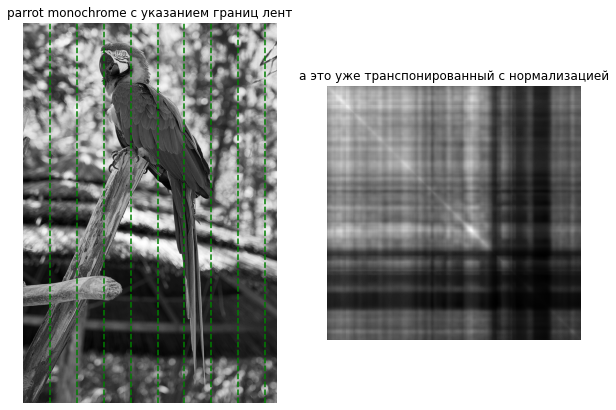

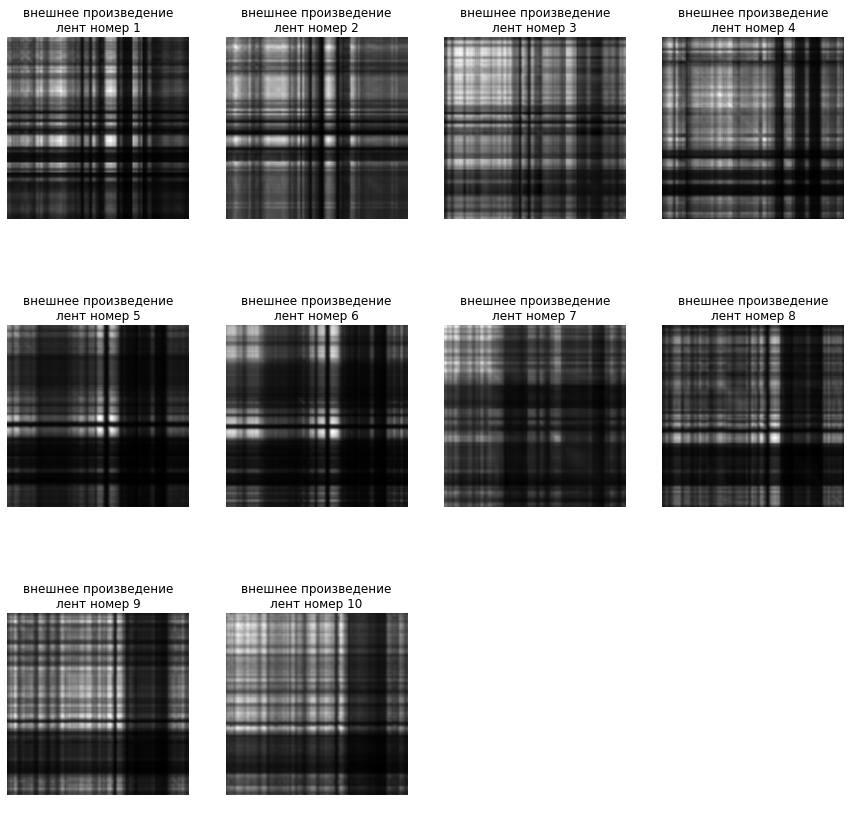

In [11]:
# функция, которая рисует произведение матрицы на транспонированную с нормализацией и все внешние умножения лент 
# попробуем в эту функцию добавить сетку
def plot_block_outer_product_trans_decomposition (picture, picture_name, strip_width=100, images_per_row=4):
    C, sum_outer_product = block_outer_product_trans_decomposition(picture, strip_width)
    num_images = len(C)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 15))
    axes[0].imshow(picture, cmap='gray')
    axes[0].set_title(f'{picture_name} monochrome с указанием границ лент')
    axes[0].axis('off')
    
    height, width = picture.shape[:2]

# Добавляем вертикальные линии сетки каждые 'strip_width' пикселей
    for i in range(strip_width, width, strip_width):
        axes[0].axvline(x=i, color='green', linestyle='--')

    
    axes[1].imshow(sum_outer_product, cmap='gray')
    axes[1].set_title('а это уже транспонированный с нормализацией')
    axes[1].axis('off')

    plt.show()
    
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 5*num_rows))
    
    for i in range(num_images):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axs[row_index, col_index].imshow(C[i], cmap = 'gray')
        axs[row_index, col_index].axis('off')
        axs[row_index, col_index].set_title(wrap_text(f'внешнее произведение лент номер {i+1}', 20))
    
    for i in range(num_images, num_rows * images_per_row):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axs[row_index, col_index].axis('off')
    
    plt.show()

plot_block_outer_product_trans_decomposition (parrot, 'parrot', strip_width=100, images_per_row=4)

In [12]:
t2_itogo = tm.time()
print('вся тетрадка заняла', round(t2_itogo - t1_itogo)//60,'минут', round(t2_itogo - t1_itogo)%60,'секунд')

вся тетрадка заняла 0 минут 4 секунд
